# Custom ByteLevel BPE tokenizer and models

Шаги: обучение токенизатора, метрики и график, простая GRU LM, дообучение GPT-2 124M с кастомным токенизатором.

In [1]:
# Optional: ensure accelerate is present for Trainer
!pip install -q "accelerate>=0.26.0"

In [ ]:
# Ensure corpus is extracted
from pathlib import Path
import zipfile
DATA_DIR = Path('dataverse_files/texts')
DATA_ZIP = Path('dataverse_files/texts.zip')
if DATA_ZIP.exists() and not DATA_DIR.exists():
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(DATA_ZIP) as z: z.extractall(DATA_DIR)
    print('Extracted texts.zip ->', DATA_DIR)
else:
    print('Data dir ready:', DATA_DIR)


In [2]:
import json
import math
import random
import re
from collections import Counter
from pathlib import Path
from typing import Dict, List

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tokenizers import Tokenizer
from tokenizers.decoders import ByteLevel as ByteLevelDecoder
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import ByteLevel
from tokenizers.processors import ByteLevel as ByteLevelProcessor
from tokenizers.trainers import BpeTrainer
from transformers import (
    DataCollatorForLanguageModeling,
    GPT2LMHeadModel,
    PreTrainedTokenizerFast,
    Trainer,
    TrainingArguments,
)

RANDOM_SEED = 42
DATA_DIR = Path("dataverse_files/texts")
ARTIFACTS = Path("artifacts")
TOKENIZER_DIR = ARTIFACTS / "tokenizer_final"
PLOTS_DIR = ARTIFACTS / "plots"
METRICS_PATH = ARTIFACTS / "tokenizer_metrics.json"
VOCAB_SIZES = [1000, 2000, 4000, 8000, 12000]
FINAL_VOCAB_SIZE = 12000
SPECIAL_TOKENS = ["<pad>", "<s>", "</s>", "<unk>"]

random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
ARTIFACTS.mkdir(exist_ok=True, parents=True)
PLOTS_DIR.mkdir(exist_ok=True, parents=True)

In [3]:
def read_texts(paths: List[Path]) -> List[str]:
    return [p.read_text(encoding="utf-8") for p in paths]


def split_corpus():
    paths = sorted(DATA_DIR.glob("*.txt"))
    rng = random.Random(RANDOM_SEED)
    rng.shuffle(paths)
    split_idx = int(0.8 * len(paths))
    return paths[:split_idx], paths[split_idx:]


def train_bpe_tokenizer(vocab_size: int, files: List[Path]):
    tok = Tokenizer(BPE(unk_token="<unk>"))
    tok.pre_tokenizer = ByteLevel(add_prefix_space=True)
    tok.decoder = ByteLevelDecoder()
    tok.post_processor = ByteLevelProcessor(trim_offsets=False)
    trainer = BpeTrainer(
        vocab_size=vocab_size,
        min_frequency=2,
        special_tokens=SPECIAL_TOKENS,
    )
    tok.train(files=[str(p) for p in files], trainer=trainer)
    return tok


def words_from_texts(texts: List[str]) -> Counter:
    pattern = re.compile(r"\w+", flags=re.UNICODE)
    cnt = Counter()
    for t in texts:
        cnt.update(pattern.findall(t))
    return cnt


def token_length_for_words(tok: Tokenizer, counter: Counter) -> float:
    total_tokens = 0
    total_occ = 0
    for w, c in counter.items():
        total_tokens += len(tok.encode(w).ids) * c
        total_occ += c
    return total_tokens / total_occ if total_occ else math.nan


def token_length_for_top_words(tok: Tokenizer, counter: Counter, frac: float = 0.1) -> float:
    if not counter:
        return math.nan
    top_k = max(1, int(len(counter) * frac))
    total_tokens = 0
    total_occ = 0
    for w, c in counter.most_common(top_k):
        total_tokens += len(tok.encode(w).ids) * c
        total_occ += c
    return total_tokens / total_occ if total_occ else math.nan


def compute_metrics(tok: Tokenizer, texts: List[str]) -> Dict:
    enc = tok.encode_batch(texts)
    token_counts = [len(e.ids) for e in enc]
    total_tokens = sum(token_counts)
    total_bytes = sum(len(t.encode("utf-8")) for t in texts)
    total_chars = sum(len(t) for t in texts)
    words = words_from_texts(texts)
    return {
        "total_tokens": total_tokens,
        "total_bytes": total_bytes,
        "total_chars": total_chars,
        "compression_tokens_per_byte": total_tokens / total_bytes if total_bytes else math.nan,
        "compression_tokens_per_char": total_tokens / total_chars if total_chars else math.nan,
        "mean_tokens_per_word": token_length_for_words(tok, words),
        "mean_tokens_per_word_top10pct": token_length_for_top_words(tok, words),
        "word_types": len(words),
        "word_tokens": sum(words.values()),
    }


def domain_metrics(tok: Tokenizer, domains: Dict[str, List[str]]):
    return {k: compute_metrics(tok, v) for k, v in domains.items()}


def collect_unused_tokens(tok: Tokenizer, texts: List[str]):
    used = set()
    for enc in tok.encode_batch(texts):
        used.update(enc.ids)
    vocab_size = tok.get_vocab_size()
    unused = vocab_size - len(used)
    return {"unused_count": unused, "unused_fraction": unused / vocab_size if vocab_size else math.nan}


def build_vocab_curve(train_paths: List[Path], eval_texts: List[str]):
    ratios = []
    for size in VOCAB_SIZES:
        tok = train_bpe_tokenizer(size, train_paths)
        m = compute_metrics(tok, eval_texts)
        ratios.append((size, m["compression_tokens_per_byte"]))
    xs, ys = zip(*ratios)
    plt.figure(figsize=(7, 4))
    plt.plot(xs, ys, marker="o")
    plt.xlabel("Vocab size")
    plt.ylabel("Tokens per byte")
    plt.title("Vocab size vs compression (lower is better)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "vocab_vs_compression.png", dpi=200)
    return ratios

{'final_vocab_size': 12000,
 'holdout_metrics': {'total_tokens': 48351,
  'total_bytes': 247321,
  'total_chars': 140581,
  'compression_tokens_per_byte': 0.1954989669296178,
  'compression_tokens_per_char': 0.34393694738264774,
  'mean_tokens_per_word': 1.5208259325044404,
  'mean_tokens_per_word_top10pct': 1.0657175102005383,
  'word_types': 10133,
  'word_tokens': 22520},
 'domain_metrics': {'poetry_holdout': {'total_tokens': 48351,
   'total_bytes': 247321,
   'total_chars': 140581,
   'compression_tokens_per_byte': 0.1954989669296178,
   'compression_tokens_per_char': 0.34393694738264774,
   'mean_tokens_per_word': 1.5208259325044404,
   'mean_tokens_per_word_top10pct': 1.0657175102005383,
   'word_types': 10133,
   'word_tokens': 22520},
  'metadata': {'total_tokens': 416763,
   'total_bytes': 1248118,
   'total_chars': 775579,
   'compression_tokens_per_byte': 0.3339131396230164,
   'compression_tokens_per_char': 0.5373572518080041,
   'mean_tokens_per_word': 2.173952820202631,


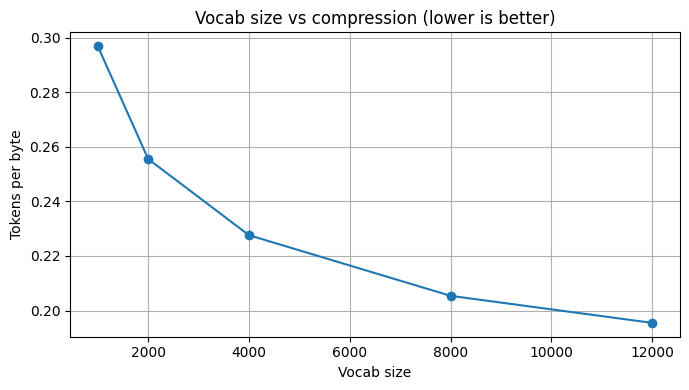

In [4]:
train_paths, holdout_paths = split_corpus()
train_texts = read_texts(train_paths)
holdout_texts = read_texts(holdout_paths)

tokenizer = train_bpe_tokenizer(FINAL_VOCAB_SIZE, train_paths)
TOKENIZER_DIR.mkdir(parents=True, exist_ok=True)
tokenizer.save(str(TOKENIZER_DIR / "tokenizer.json"))

holdout_metrics = compute_metrics(tokenizer, holdout_texts)
metadata_text = Path("dataverse_files/metadata.tsv").read_text(encoding="utf-8")
bibliography_text = Path("dataverse_files/bibliography.tsv").read_text(encoding="utf-8")
domain_texts = {
    "poetry_holdout": holdout_texts,
    "metadata": [metadata_text],
    "bibliography": [bibliography_text],
}
domains = domain_metrics(tokenizer, domain_texts)
curve = build_vocab_curve(train_paths, holdout_texts)
unused = collect_unused_tokens(tokenizer, read_texts(sorted(DATA_DIR.glob("*.txt"))))

result = {
    "final_vocab_size": FINAL_VOCAB_SIZE,
    "holdout_metrics": holdout_metrics,
    "domain_metrics": domains,
    "vocab_curve": [{"vocab_size": s, "tokens_per_byte": r} for s, r in curve],
    "unused_tokens": unused,
    "train_files_count": len(train_paths),
    "holdout_files_count": len(holdout_paths),
}
METRICS_PATH.write_text(json.dumps(result, ensure_ascii=False, indent=2), encoding="utf-8")
result

## Simple GRU language model

In [5]:
class LMSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, tokens: torch.Tensor, seq_len: int):
        self.tokens = tokens
        self.seq_len = seq_len

    def __len__(self):
        return len(self.tokens) - self.seq_len

    def __getitem__(self, idx):
        x = self.tokens[idx: idx + self.seq_len]
        y = self.tokens[idx + 1: idx + self.seq_len + 1]
        return x, y


class TinyGRULM(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int = 256, hidden_dim: int = 256):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim, batch_first=True)
        self.proj = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        emb = self.embed(x)
        out, _ = self.rnn(emb)
        return self.proj(out)


def load_token_ids(tok: Tokenizer, files: List[Path], max_tokens: int = 120_000) -> torch.Tensor:
    ids = []
    for p in files:
        ids.extend(tok.encode(p.read_text(encoding="utf-8")).ids)
        if len(ids) >= max_tokens:
            break
    return torch.tensor(ids[:max_tokens], dtype=torch.long)

In [6]:
seq_len = 64
token_tensor = load_token_ids(tokenizer, train_paths)
dataset = LMSequenceDataset(token_tensor, seq_len)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

model = TinyGRULM(tokenizer.get_vocab_size())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

for epoch in range(2):
    model.train()
    tot = 0.0
    batches = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        logits = model(x)
        loss = crit(logits.view(-1, logits.size(-1)), y.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        tot += loss.item()
        batches += 1
    avg = tot / batches
    print(f"Epoch {epoch+1}: loss={avg:.4f}, ppl={math.exp(avg):.2f}")

ARTIFACTS.joinpath("simple_model").mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), ARTIFACTS / "simple_model" / "tiny_gru_lm.pt")

Epoch 1: loss=2.1790, ppl=8.84


Epoch 2: loss=0.3439, ppl=1.41


## Fine-tune GPT-2 (124M) with custom tokenizer

Короткий прогон (50 шагов) для демонстрации замены токенизатора.

In [7]:
train_subset = train_paths[:120]
train_texts = [p.read_text(encoding="utf-8") for p in train_subset]

hf_tokenizer = PreTrainedTokenizerFast(
    tokenizer_file=str(TOKENIZER_DIR / "tokenizer.json"),
    bos_token="<s>",
    eos_token="</s>",
    unk_token="<unk>",
    pad_token="<pad>",
)
hf_tokenizer.padding_side = "right"


class BlockDataset(torch.utils.data.Dataset):
    def __init__(self, texts: List[str], tok: PreTrainedTokenizerFast, block_size: int = 128):
        joined = "\n\n".join(texts)
        encoded = tok(joined, return_tensors="pt", add_special_tokens=False).input_ids[0]
        blocks = len(encoded) // block_size
        encoded = encoded[: blocks * block_size]
        self.examples = encoded.view(blocks, block_size)

    def __len__(self):
        return self.examples.size(0)

    def __getitem__(self, idx):
        return {"input_ids": self.examples[idx]}


block_dataset = BlockDataset(train_texts, hf_tokenizer)

model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(hf_tokenizer))
model.config.pad_token_id = hf_tokenizer.pad_token_id

collator = DataCollatorForLanguageModeling(tokenizer=hf_tokenizer, mlm=False)

args = TrainingArguments(
    output_dir=str(ARTIFACTS / "gpt2_custom"),
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=2,
    learning_rate=5e-5,
    warmup_steps=0,
    logging_steps=10,
    save_strategy="no",
    eval_strategy="no",
    max_steps=50,
    seed=RANDOM_SEED,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=block_dataset,
    data_collator=collator,
)
train_result = trainer.train()
(ARTIFACTS / "gpt2_custom").mkdir(parents=True, exist_ok=True)
trainer.save_model(str(ARTIFACTS / "gpt2_custom"))
print(train_result.metrics)

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,8.609900
20,7.761800
30,7.494700
40,7.471000
50,7.330400


{'train_runtime': 6.1029, 'train_samples_per_second': 16.386, 'train_steps_per_second': 8.193, 'total_flos': 6532300800000.0, 'train_loss': 7.733583526611328, 'epoch': 0.5025125628140703}
